### Imports

In [6]:
import pandas as pd
from pandas_datareader import data
from datetime import datetime
import matplotlib.pyplot as plt
import time

### Obtain and Prepare Data

In [7]:
start = datetime.strptime('2020-01-02','%Y-%m-%d')
end = datetime.strptime('2022-02-28','%Y-%m-%d')

df = data.DataReader('^HSI',start=start, end=end, data_source='yahoo')
df = df[:1500]['Close']

In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(np.array(df).reshape(-1,1))

In [9]:
training_size=int(len(data)*0.65)
test_size=len(data)-training_size
train_data,test_data=data[0:training_size,:],data[training_size:len(data),:]

In [10]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [11]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

### Build and Train LSTM

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [14]:
model=Sequential() 
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1))) 
model.add(LSTM(50,return_sequences=True)) 
model.add(LSTM(50)) 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error',optimizer='adam')

In [15]:
start= time.time()
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)
end=time.time()

Epoch 1/100
4/4 [==============================] - 5s 398ms/step - loss: 0.2692 - val_loss: 0.0212
Epoch 2/100
4/4 [==============================] - 0s 118ms/step - loss: 0.0599 - val_loss: 0.0590
Epoch 3/100
4/4 [==============================] - 0s 126ms/step - loss: 0.0442 - val_loss: 0.0311
Epoch 4/100
4/4 [==============================] - 0s 121ms/step - loss: 0.0149 - val_loss: 0.0066
Epoch 5/100
4/4 [==============================] - 0s 121ms/step - loss: 0.0270 - val_loss: 0.0077
Epoch 6/100
4/4 [==============================] - 0s 123ms/step - loss: 0.0150 - val_loss: 0.0213
Epoch 7/100
4/4 [==============================] - 0s 122ms/step - loss: 0.0126 - val_loss: 0.0360
Epoch 8/100
4/4 [==============================] - 0s 124ms/step - loss: 0.0135 - val_loss: 0.0202
Epoch 9/100
4/4 [==============================] - 0s 116ms/step - loss: 0.0096 - val_loss: 0.0112
Epoch 10/100
4/4 [==============================] - 0s 125ms/step - loss: 0.0106 - val_loss: 0.0121
Epoch 11/

4/4 [==============================] - 0s 117ms/step - loss: 0.0050 - val_loss: 0.0062
Epoch 84/100
4/4 [==============================] - 0s 112ms/step - loss: 0.0047 - val_loss: 0.0061
Epoch 85/100
4/4 [==============================] - 0s 116ms/step - loss: 0.0049 - val_loss: 0.0060
Epoch 86/100
4/4 [==============================] - 0s 117ms/step - loss: 0.0045 - val_loss: 0.0067
Epoch 87/100
4/4 [==============================] - 0s 112ms/step - loss: 0.0045 - val_loss: 0.0055
Epoch 88/100
4/4 [==============================] - 0s 114ms/step - loss: 0.0045 - val_loss: 0.0065
Epoch 89/100
4/4 [==============================] - 0s 111ms/step - loss: 0.0044 - val_loss: 0.0057
Epoch 90/100
4/4 [==============================] - 0s 112ms/step - loss: 0.0041 - val_loss: 0.0067
Epoch 91/100
4/4 [==============================] - 0s 116ms/step - loss: 0.0042 - val_loss: 0.0055
Epoch 92/100
4/4 [==============================] - 0s 119ms/step - loss: 0.0041 - val_loss: 0.0066
Epoch 93/100


### Make Predictions

In [16]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Visualize Results

<function matplotlib.pyplot.show(close=None, block=None)>

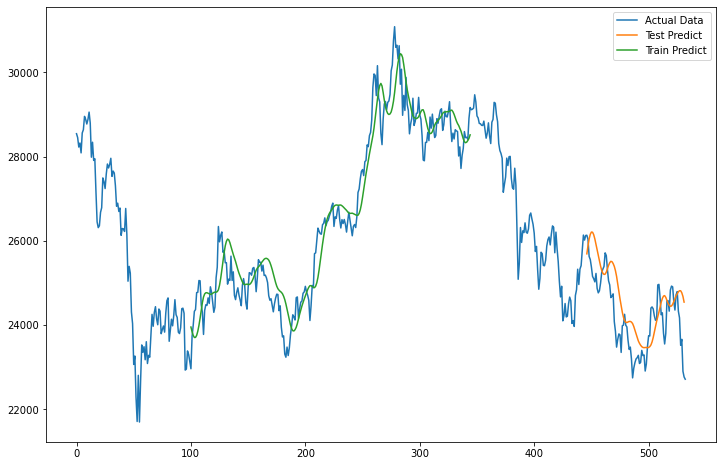

In [17]:
look_back=time_step
trainPredictPlot=np.empty_like(data)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

testPredictPlot=np.empty_like(data)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1,:] = test_predict

plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data))
plt.plot(testPredictPlot)
plt.plot(trainPredictPlot)
plt.legend(['Actual Data','Test Predict','Train Predict'])

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

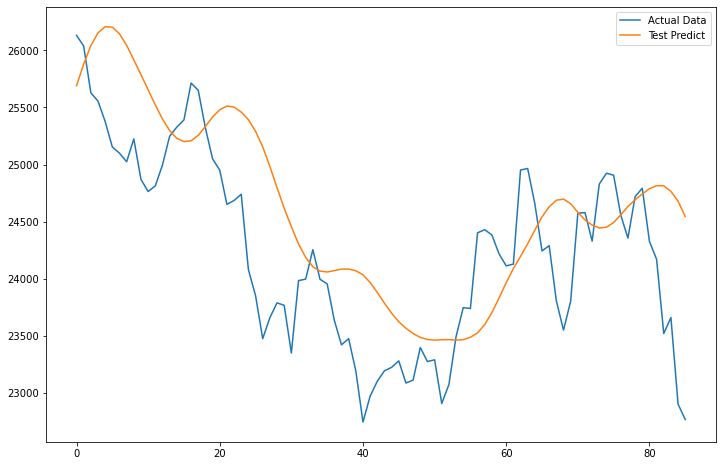

In [18]:
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data)[len(train_predict)+(look_back*2)+1:len(data)-1])
plt.plot(test_predict)
plt.legend(['Actual Data','Test Predict'])
plt.show

### Evaluation

In [19]:
from sklearn.metrics import mean_squared_error
test_predict=model.predict(X_test)
print('MSE:',mean_squared_error(y_test, test_predict))

MSE: 0.005968016852495278


In [20]:
print('Volatility:',np.log(df/df.shift()).std()*252**0.5)

Volatility: 0.21935700017598445


In [21]:
print('Time taken for training in seconds:',end-start)

Time taken for training in seconds: 49.51966094970703
